In [1]:
# Simulated Data Generation
import numpy as np
import pandas as pd

# Simulate a clean sine wave
t = np.linspace(0, 100, 1000)
clean_data = np.sin(t)

# Inject anomalies
corrupted_data = clean_data.copy()
corrupted_data[100:110] += 5  # spike anomaly
corrupted_data[300:310] -= 4  # dip anomaly

# Create DataFrame with proper InfluxDB formatting
df = pd.DataFrame({
    "timestamp": pd.date_range(start="2025-01-01", periods=1000, freq="s"),
    "value": corrupted_data
})

# Convert timestamp to RFC3339 format (ISO8601 with 'T' separator and 'Z' timezone)
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Save to CSV with proper formatting for InfluxDB
df.to_csv("anomaly_data.csv", index=False)

print("Successfully generated anomaly data with:")
print(f"- Timestamp range: {df['timestamp'].iloc[0]} to {df['timestamp'].iloc[-1]}")
print(f"- Anomalies injected at positions 100-109 (spike) and 300-309 (dip)")
print(f"- File saved as 'anomaly_data.csv'")

Successfully generated anomaly data with:
- Timestamp range: 2025-01-01T00:00:00Z to 2025-01-01T00:16:39Z
- Anomalies injected at positions 100-109 (spike) and 300-309 (dip)
- File saved as 'anomaly_data.csv'


In [2]:
# Autoencoder-Based Anomaly Detection Pipeline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# 1. Simulate Time Series Data
t = np.linspace(0, 100, 1000)
clean_data = np.sin(t)

# Inject anomalies
corrupted_data = clean_data.copy()
corrupted_data[100:110] += 5  # spike anomaly
corrupted_data[300:310] -= 4  # dip anomaly

# Create DataFrame with proper InfluxDB formatting
df = pd.DataFrame({
    "timestamp": pd.date_range(start="2025-01-01", periods=1000, freq="s"),
    "value": corrupted_data
})

# 2. Data Preprocessing
scaler = MinMaxScaler()
X = df[['value']].values
X_scaled = scaler.fit_transform(X)

# 3. Define Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 4. Train the Model
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

for epoch in range(200):
    output = model(X_tensor)
    loss = criterion(output, X_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# 5. Detect Anomalies
with torch.no_grad():
    reconstructed = model(X_tensor).numpy()
    
mse = ((X_scaled - reconstructed) ** 2).mean(axis=1)
df['anomaly_score'] = mse
df['anomaly'] = (df['anomaly_score'] > np.percentile(mse, 99)).astype(int)

# 6. Prepare for InfluxDB
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Save results
df.to_csv("anomaly_detection_results.csv", index=False)

print("\nAnomaly Detection Complete:")
print(f"- Total anomalies detected: {df['anomaly'].sum()}")
print(f"- Results saved to 'anomaly_detection_results.csv'")
print("Columns in output:", df.columns.tolist())

Epoch 50, Loss: 0.0101
Epoch 100, Loss: 0.0095
Epoch 150, Loss: 0.0088
Epoch 200, Loss: 0.0078

Anomaly Detection Complete:
- Total anomalies detected: 10
- Results saved to 'anomaly_detection_results.csv'
Columns in output: ['timestamp', 'value', 'anomaly_score', 'anomaly']


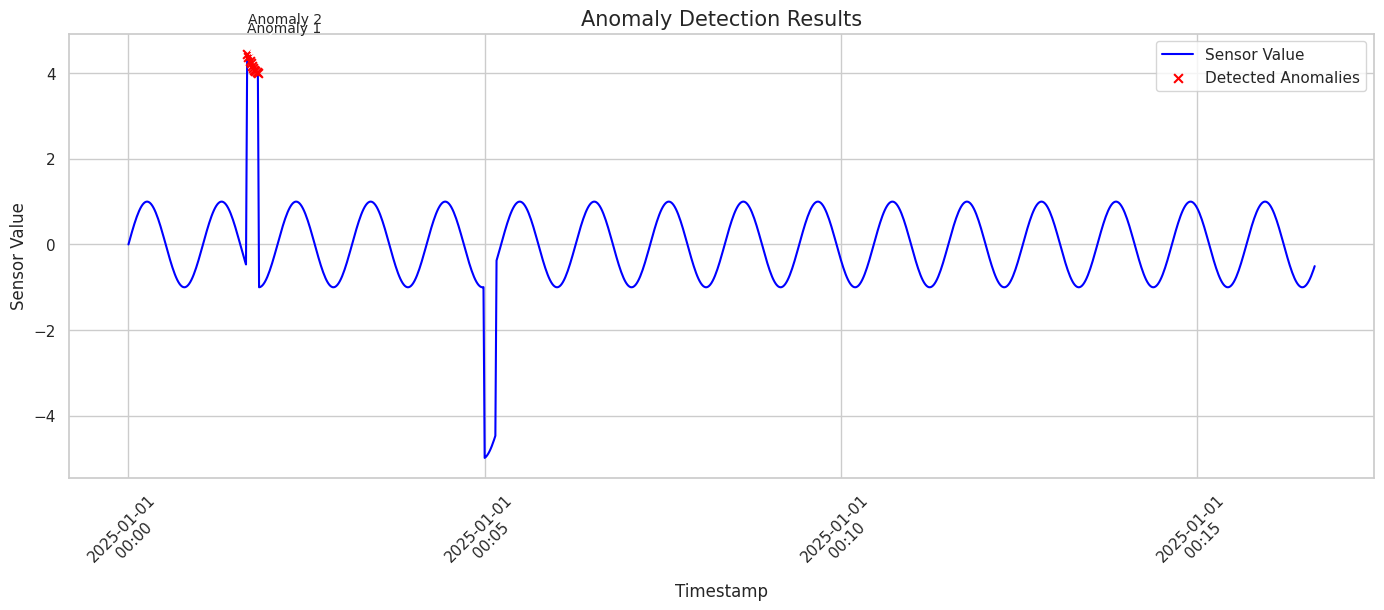

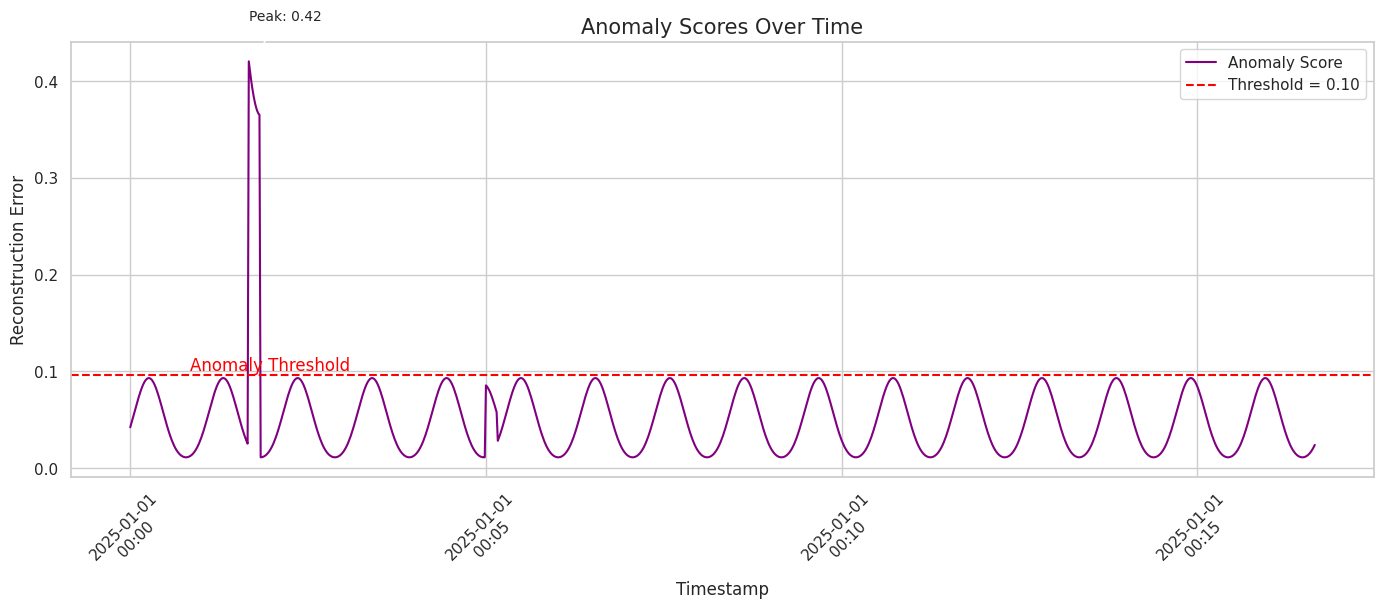


=== Anomaly Detection Summary ===
Total Data Points: 1000
Anomalies Detected: 10
Detection Rate (%): 1.0
Max Anomaly Score: 0.4205
Mean Anomaly Score: 0.0516
Score Std Dev: 0.0445
Threshold Used: 0.0959

Results saved to 'anomaly_detection_results.csv'


In [3]:
# Autoencoder-Based Anomaly Detection with Visualization
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# 1. Simulate Time Series Data
t = np.linspace(0, 100, 1000)
clean_data = np.sin(t)

# Inject anomalies
corrupted_data = clean_data.copy()
corrupted_data[100:110] += 5  # spike anomaly
corrupted_data[300:310] -= 4  # dip anomaly

# Create DataFrame
df = pd.DataFrame({
    "timestamp": pd.date_range(start="2025-01-01", periods=1000, freq="s"),
    "value": corrupted_data
})

# 2. Data Preprocessing
scaler = MinMaxScaler()
X = df[['value']].values
X_scaled = scaler.fit_transform(X)

# 3. Define and Train Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 1))
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
for epoch in range(200):
    output = model(X_tensor)
    loss = criterion(output, X_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 4. Detect Anomalies
with torch.no_grad():
    reconstructed = model(X_tensor).numpy()
    
mse = ((X_scaled - reconstructed) ** 2).mean(axis=1)
df['anomaly_score'] = mse
df['anomaly'] = (df['anomaly_score'] > np.percentile(mse, 99)).astype(int)

# 5. Visualization
sns.set(style='whitegrid')

# Anomaly Detection Plot
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['value'], label='Sensor Value', color='blue', linewidth=1.5)
plt.scatter(df[df['anomaly'] == 1]['timestamp'], df[df['anomaly'] == 1]['value'],
            color='red', label='Detected Anomalies', s=40, marker='x', zorder=3)

# Highlight example anomalies
for i, anomaly in enumerate(df[df['anomaly'] == 1].iloc[:2].iterrows()):
    plt.annotate(f'Anomaly {i+1}',
                 xy=(anomaly[1]['timestamp'], anomaly[1]['value']),
                 xytext=(anomaly[1]['timestamp'], anomaly[1]['value'] + 0.5 + (i*0.3)),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10)

plt.title('Anomaly Detection Results', fontsize=15)
plt.xlabel('Timestamp')
plt.ylabel('Sensor Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.savefig('anomaly_detection_results.png', dpi=300)
plt.show()

# Anomaly Score Plot
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['anomaly_score'], label='Anomaly Score', color='purple', linewidth=1.5)
threshold = np.percentile(mse, 99)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')

# Annotate threshold and peak
plt.text(df['timestamp'].iloc[50], threshold*1.05, 'Anomaly Threshold', color='red')
peak_idx = df['anomaly_score'].idxmax()
plt.annotate(f'Peak: {df["anomaly_score"][peak_idx]:.2f}',
             xy=(df['timestamp'][peak_idx], df['anomaly_score'][peak_idx]),
             xytext=(df['timestamp'][peak_idx], df['anomaly_score'][peak_idx] * 1.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

plt.title('Anomaly Scores Over Time', fontsize=15)
plt.xlabel('Timestamp')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.savefig('anomaly_scores.png', dpi=300)
plt.show()

# 6. Summary Statistics
summary_stats = {
    'Total Data Points': len(df),
    'Anomalies Detected': df['anomaly'].sum(),
    'Detection Rate (%)': round(df['anomaly'].mean() * 100, 2),
    'Max Anomaly Score': round(df['anomaly_score'].max(), 4),
    'Mean Anomaly Score': round(df['anomaly_score'].mean(), 4),
    'Score Std Dev': round(df['anomaly_score'].std(), 4),
    'Threshold Used': round(threshold, 4)
}

print("\n=== Anomaly Detection Summary ===")
for k, v in summary_stats.items():
    print(f"{k}: {v}")
    
# 7. Save Results for InfluxDB
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')
df.to_csv("anomaly_detection_results.csv", index=False)
print("\nResults saved to 'anomaly_detection_results.csv'")

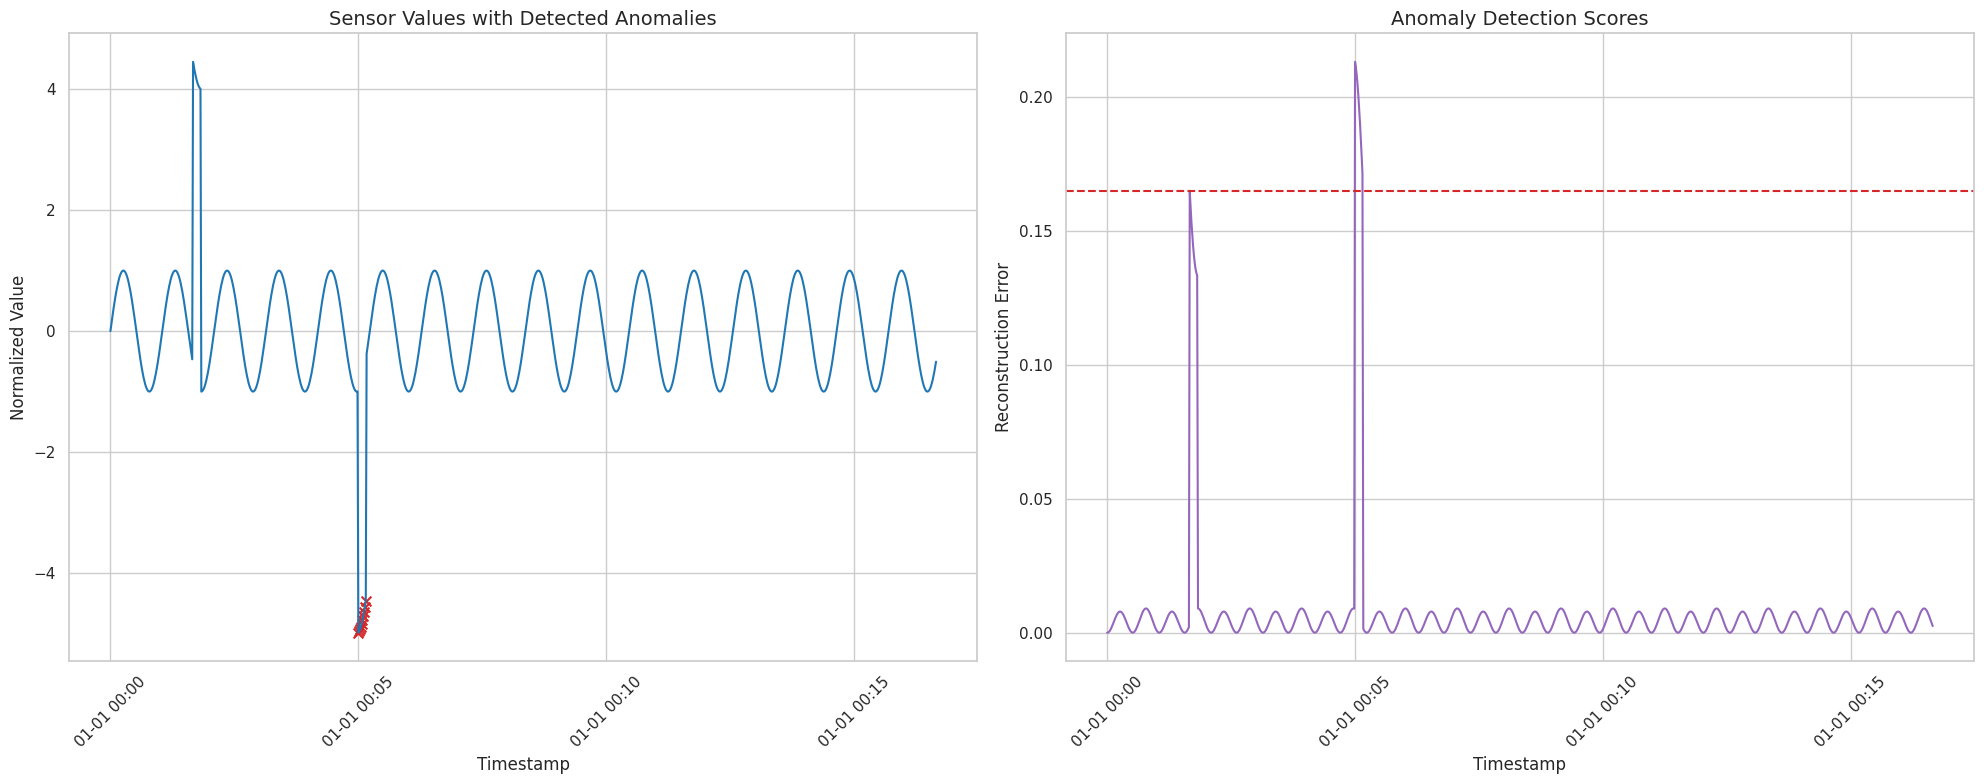

In [ ]:
# Autoencoder Anomaly Detection Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Convert timestamp strings to datetime objects for plotting
df['timestamp_dt'] = pd.to_datetime(df['timestamp'])

# Set up the figure
plt.figure(figsize=(20, 8))
sns.set(style='whitegrid', palette='muted')

# --- Left Plot: Anomaly Detection ---
ax1 = plt.subplot(1, 2, 1)
plt.plot(df['timestamp_dt'], df['value'], label='Sensor Value', color='#1f77b4', linewidth=1.5)
plt.scatter(df[df['anomaly'] == 1]['timestamp_dt'], 
            df[df['anomaly'] == 1]['value'],
            color='#d62728', label='Detected Anomalies', s=50, marker='x')

# Format x-axis with dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title('Sensor Values with Detected Anomalies', fontsize=14)

# --- Right Plot: Anomaly Scores ---
ax2 = plt.subplot(1, 2, 2)
threshold = np.percentile(df['anomaly_score'], 99)
plt.plot(df['timestamp_dt'], df['anomaly_score'], label='Anomaly Score', color='#9467bd')
plt.axhline(y=threshold, color='#d62728', linestyle='--', label=f'Threshold: {threshold:.2f}')

# Format x-axis with dates
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Reconstruction Error', fontsize=12)
plt.title('Anomaly Detection Scores', fontsize=14)

# Adjust layout and display
plt.tight_layout()
plt.show()